In [36]:
#Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras

# Import of keras model and hidden layers for our convolutional network
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout

#Image handling libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

#Sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#Initialize a list of paths for images
imagepaths = []

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        #print(os.path.join(dirname, filename))
        if path.endswith("png"):
            imagepaths.append(path)

print(len(imagepaths))
#print(imagepaths)

40000


In [37]:
#Defining a function that plots the image selected from a path

def img_plot(img_path):
    img = cv2.imread(img_path)
    #convert to RGB space
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #check the shape of the image
    print("Shape of the image is ", img_rgb.shape)
    #Display the image
    plt.grid(False)
    plt.imshow(img_rgb)
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.title("Image " + img_path)

Shape of the image is  (240, 640)


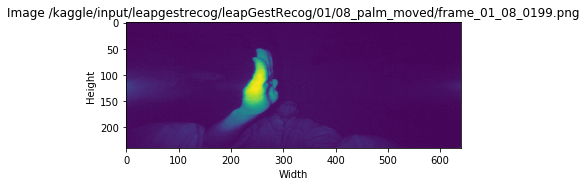

In [38]:
#Example image plot
#Plotting the first image from the dataset
img_plot(imagepaths[0])

In [39]:
X = [] # Image data
y = [] # Labels

# Loops through imagepaths to load images and labels into arrays
for path in imagepaths:
  img = cv2.imread(path) # Reads image and returns np.array
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
  img = cv2.resize(img, (320, 120)) # Reduce image size so training can be faster
  X.append(img)
  

  # Processing label in image path
  category = path.split("_")[3][1]
   # We need to convert 10_down to 00_down, or else it crashes
  y.append(int(category))

# Turn X and y into np.array to speed up train_test_split
X = np.array(X, dtype="uint8")
X = X.reshape(len(imagepaths), 320, 120, 1)# Needed to reshape so CNN knows it's different images
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))


print(y[0], imagepaths[0]) # Debugging

Images loaded:  40000
Labels loaded:  40000
1 /kaggle/input/leapgestrecog/leapGestRecog/01/08_palm_moved/frame_01_08_0199.png


In [40]:
y.shape

(40000,)

In [41]:
# Make the test train split
threshold = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = threshold, random_state = 42)

In [42]:
# Create a CNN Sequential Model
model = Sequential()
model.add(Conv2D(32, (5,5), activation = 'relu', input_shape=(320,120,1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))


In [43]:
#Model configuration for training purpose
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [44]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 316, 116, 32)      832       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 158, 58, 32)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 156, 56, 64)       18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 78, 28, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 76, 26, 128)       73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 38, 13, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 36, 11, 128)      

In [45]:
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2, 
         validation_data=(X_test, y_test))

Train on 28000 samples, validate on 12000 samples
Epoch 1/5
 - 26s - loss: 0.6897 - accuracy: 0.8856 - val_loss: 0.0352 - val_accuracy: 0.9851
Epoch 2/5
 - 21s - loss: 0.0443 - accuracy: 0.9827 - val_loss: 0.0168 - val_accuracy: 0.9911
Epoch 3/5
 - 21s - loss: 0.0246 - accuracy: 0.9885 - val_loss: 0.0155 - val_accuracy: 0.9917
Epoch 4/5
 - 21s - loss: 0.0304 - accuracy: 0.9874 - val_loss: 0.0260 - val_accuracy: 0.9874
Epoch 5/5
 - 21s - loss: 0.0264 - accuracy: 0.9886 - val_loss: 0.0167 - val_accuracy: 0.9911


In [47]:
model.save('handgesturerecog_model.h5')

**TESTING THE MODEL**

In [55]:
#calculate loss and accuracy on test data

tLoss, tAccuracy = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(tAccuracy*100))

12000/12000 [==============================] - 3s 289us/step
Test accuracy: 99.13%


In [56]:
# Making predictions on test data
prediction = model.predict(X_test)

In [57]:
#Lets compare the predicted value with actual label value
# Ideally both prediction[0] and y_test[0] should be same
np.argmax(prediction[0]), y_test[0]

(1, 1)

In [58]:
# Function to plot images and labels for validation purposes
def validate_gestures(predictions_array, true_label_array, img_array):
  # Array for pretty printing and then figure size
  class_names = ["down", "palm", "l", "fist", "fist_moved", "thumb", "index", "ok", "palm_moved", "c"] 
  plt.figure(figsize=(15,5))
  
  for i in range(1, 10):
    # Just assigning variables
    prediction = predictions_array[i]
    true_label = true_label_array[i]
    img = img_array[i]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Plot in a good way
    plt.subplot(3,3,i)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction) # Get index of the predicted label from prediction
    
    # Change color of title based on good prediction or not
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'

    plt.xlabel("Predicted: {} {:2.0f}% (Actual: {})".format(class_names[predicted_label],
                                  100*np.max(prediction),
                                  class_names[true_label]),
                                  color=color)
  plt.show()

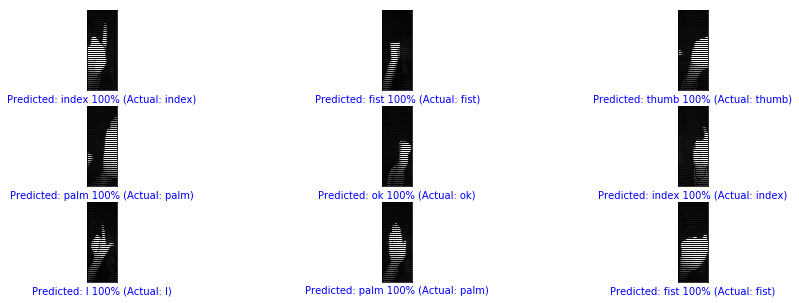

In [52]:
# Plot testing based on predictions and their actual values
validate_gestures(prediction, y_test, X_test)

In [59]:
#Transform predictions into 1D array 
y_pred = np.argmax(prediction, axis=1)


In [54]:
#Create a Confusion Matrix for Evaluation
# H = Horizontal
# V = Vertical
pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=["Predicted Thumb Down", "Predicted Palm (H)", "Predicted L", "Predicted Fist (H)", "Predicted Fist (V)", "Predicted Thumbs up", "Predicted Index", "Predicted OK", "Predicted Palm (V)", "Predicted C"],
             index=["Actual Thumb Down", "Actual Palm (H)", "Actual L", "Actual Fist (H)", "Actual Fist (V)", "Actual Thumbs up", "Actual Index", "Actual OK", "Actual Palm (V)", "Actual C"])

array([[1400,    0,    1,    0,    0,    0,    4,    0,    0,    0],
       [   0, 1467,    2,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 1417,    0,    0,   18,    0,    0,    0,    0],
       [   0,    1,    0, 1462,    0,    0,    1,    0,    0,    0],
       [   0,    0,    0,    0,  253,    0,    0,    0,    0,    0],
       [   0,    0,   66,    0,    0, 1380,    0,    2,    0,    0],
       [   0,    0,    6,    0,    0,    0, 1466,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 1456,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,  230,    0],
       [   0,    0,    0,    0,    0,    0,    3,    0,    0, 1365]])